# Stars temperature ✨

Обсерватория "Небо на ладони" прислало задачу с просьбой придумать, как с помощью нейросетей определять температуру на поверхности обнаруженных звёзд.

Требование к метрике: `RMSE <= 4500`

**Содержание**<a id='toc0_'></a>    
1. [Подготовка      ](#toc1_)    
1.1. [Библиотеки      ](#toc1_1_)    
1.2. [Конфигурация      ](#toc1_2_)    
1.3. [Сервисные функции      ](#toc1_3_)    
2. [Данные      ](#toc2_)    
2.1. [Загрузка      ](#toc2_1_)    
2.2. [Переименование признаков      ](#toc2_2_)    
2.3. [Проверка типов данных      ](#toc2_3_)    
2.4. [Обработка дубликатов      ](#toc2_4_)    
2.5. [Проверка пропусков      ](#toc2_5_)    
2.6. [Изучение таргета и признаков      ](#toc2_6_)    
2.6.1. [Таргет `temperature`      ](#toc2_6_1_)    
2.6.2. [Признак `luminosity`      ](#toc2_6_2_)    
2.6.3. [Признак `radius`      ](#toc2_6_3_)    
2.6.4. [Признак `absolute_magnitude`      ](#toc2_6_4_)    
2.6.5. [Признак `star_type`      ](#toc2_6_5_)    
2.6.6. [Признак `star_color`      ](#toc2_6_6_)    
2.7. [Корреляция     ](#toc2_7_)    
2.8. [Вывод по датафрейму     ](#toc2_8_)    
3. [Разделение данных     ](#toc3_)    
4. [Преобразование данных     ](#toc4_)    
5. [Простая сеть  ](#toc5_)    
5.1. [Создание  ](#toc5_1_)    
5.2. [Вывод  ](#toc5_2_)    
6. [Улучшение модели     ](#toc6_)    
7. [Проверка на тесте    ](#toc7_)    
8. [Общий вывод    ](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка       [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки       [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [ ]:
%pip install -q matplotlib==3.9.2
%pip install -q numpy==1.26.4
%pip install -q pandas==2.2.3
%pip install -q phik==0.12.4
%pip install -q prettytable==3.12.0
%pip install -q scikit-learn==1.5.2
%pip install -q seaborn==0.13.2
%pip install -q statsmodels==0.14.4
%pip install -q termcolor==2.5.0
%pip install -q torch==2.5.1
%pip install -q skorch

clear_output()

In [3]:
import random
from os.path import exists


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from termcolor import colored
from prettytable import PrettyTable
from phik import phik_matrix  # this import IS accessed
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import ColumnTransformer
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

### 1.2. <a id='toc1_2_'></a>Конфигурация       [&#8593;](#toc0_)

In [4]:
RANDOM_STATE = 27
TEST_SIZE = 0.2

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

import warnings
warnings.filterwarnings('ignore')

### 1.3. <a id='toc1_3_'></a>Сервисные функции       [&#8593;](#toc0_)

In [5]:
def get_dataframe(paths: list[str], **kwargs) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue

        try:
            df = pd.read_csv(_path, **kwargs)
        except:
            continue

        if df is None:
            continue

        return df

    raise FileNotFoundError('No paths are valid for correct csv file.')

In [6]:
def check_duplicates(df: pd.DataFrame) -> None:
    duplicates_count = df.duplicated().sum()

    if duplicates_count == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
    else:
        duplicates_part = duplicates_count / len(df)
        print(colored(f'Обнаружено {duplicates_count} дубликатов ({duplicates_part:.2%})', 'red'))

In [7]:
def check_nans(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [8]:
def get_value_counts(series: pd.Series) -> None:
    data = pd.DataFrame()
    data['count'] = series.value_counts()
    data['part'] =series.value_counts(normalize=True)
    display(data)

In [9]:
def draw_plots_about_column(df: pd.DataFrame,
                            column: str,
                            column_description: str = None,
                            bins: int = 20
                            ) -> None:
    if column_description is None:
        column_description = column

    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    sns.violinplot(df, x=column, ax=ax1, orient='h')
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.boxplot(df, x=column, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()

    sns.histplot(df, x=column, bins=bins, ax=ax3)
    ax3.set_xlabel(column_description)
    ax3.grid()
    ax3.set_ylabel('Количество')

    ax4.set_visible(False)

    plt.suptitle(f'Информация о колонке `{column_description}`', fontsize=18)
    plt.tight_layout()

    plt.show()

In [10]:
def replace_rare_values(df: pd.DataFrame, column: str, threshold: float = 0.05) -> pd.DataFrame:
    """Заменяет значения в указанном столбце DataFrame, которые встречаются реже заданного процента, на 'other'.

    Args:
        df (pd.DataFrame): Входной DataFrame, в котором нужно заменить значения.
        column (str): Название столбца, в котором будет происходить замена.
        threshold (float, optional): Доля, ниже которой значения будут заменены. По умолчанию 0.05.

    Returns:
        pd.DataFrame: Измененный DataFrame с замененными значениями.
    """

    # Определяем порог для замены
    threshold = threshold * len(df)

    # Получаем значения, которые встречаются реже порога
    to_replace = df[column].value_counts()[df[column].value_counts() < threshold].index

    # Заменяем их на 'other'
    df[column] = df[column].replace(to_replace, 'other')

    return df

## 2. <a id='toc2_'></a>Данные       [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка       [&#8593;](#toc0_)

In [11]:
df = get_dataframe([
    './data/data.csv',
    './data.csv',
    '/datasets/6_class.csv'
], index_col=0)

df.index.name = ''
df.sample(5)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
,,,,,,
88,13720,0.00018,0.00892,12.97,2,white
65,3295,0.00098,0.13200,17.13,0,Red
8,2650,0.00069,0.11000,17.45,0,Red
63,2835,0.00034,0.09180,16.96,0,Red
238,9235,404940.00000,1112.00000,-11.23,5,White


### 2.2. <a id='toc2_2_'></a>Переименование признаков       [&#8593;](#toc0_)

Сразу заметим, что названия признаков не соответствует PEP8. Переименуем их.

In [12]:
df.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [13]:
df = df.rename(columns={
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'absolute_magnitude',
    'Star type': 'star_type',
    'Star color': 'star_color',
})

In [14]:
df.columns

Index(['temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color'],
      dtype='object')

### 2.3. <a id='toc2_3_'></a>Проверка типов данных       [&#8593;](#toc0_)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius              240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_type           240 non-null    int64  
 5   star_color          240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


Типы данных указаны верно во всех столбцах.

### 2.4. <a id='toc2_4_'></a>Обработка дубликатов       [&#8593;](#toc0_)

In [16]:
check_duplicates(df)

Полных дубликатов не обнаружено.


### 2.5. <a id='toc2_5_'></a>Проверка пропусков       [&#8593;](#toc0_)

In [17]:
check_nans(df)

+--------------------+----------------------+
|      Feature       | Missing values count |
+--------------------+----------------------+
|    temperature     |      0 (0.00%)       |
|     luminosity     |      0 (0.00%)       |
|       radius       |      0 (0.00%)       |
| absolute_magnitude |      0 (0.00%)       |
|     star_type      |      0 (0.00%)       |
|     star_color     |      0 (0.00%)       |
+--------------------+----------------------+


Датасет не содержит пропусков.

### 2.6. <a id='toc2_6_'></a>Изучение таргета и признаков       [&#8593;](#toc0_)

#### 2.6.1. <a id='toc2_6_1_'></a>Таргет `temperature`       [&#8593;](#toc0_)

In [18]:
df['temperature'].describe()

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature, dtype: float64

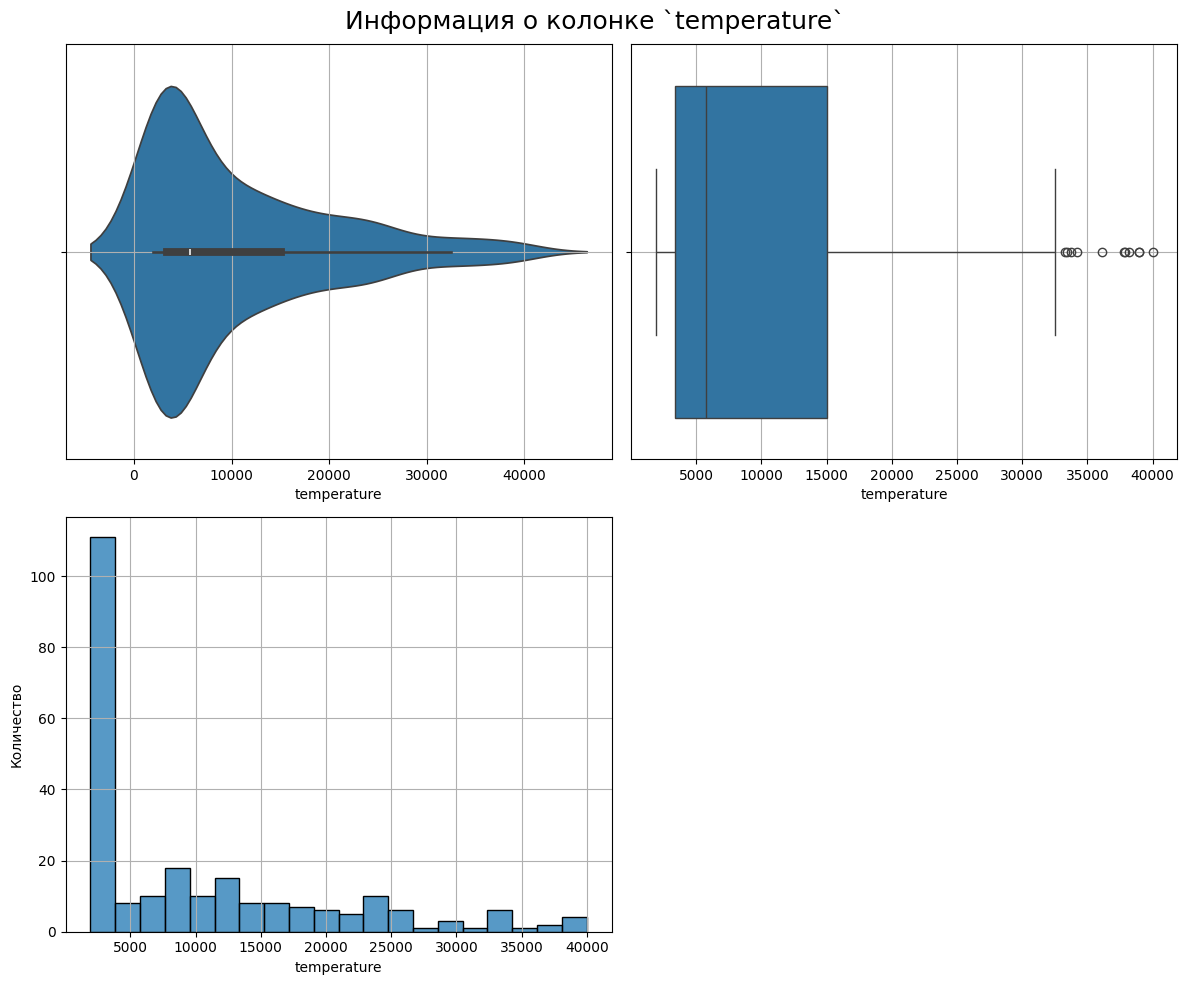

In [19]:
draw_plots_about_column(df, 'temperature')

#### 2.6.2. <a id='toc2_6_2_'></a>Признак `luminosity`       [&#8593;](#toc0_)

In [20]:
df['luminosity'].describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64

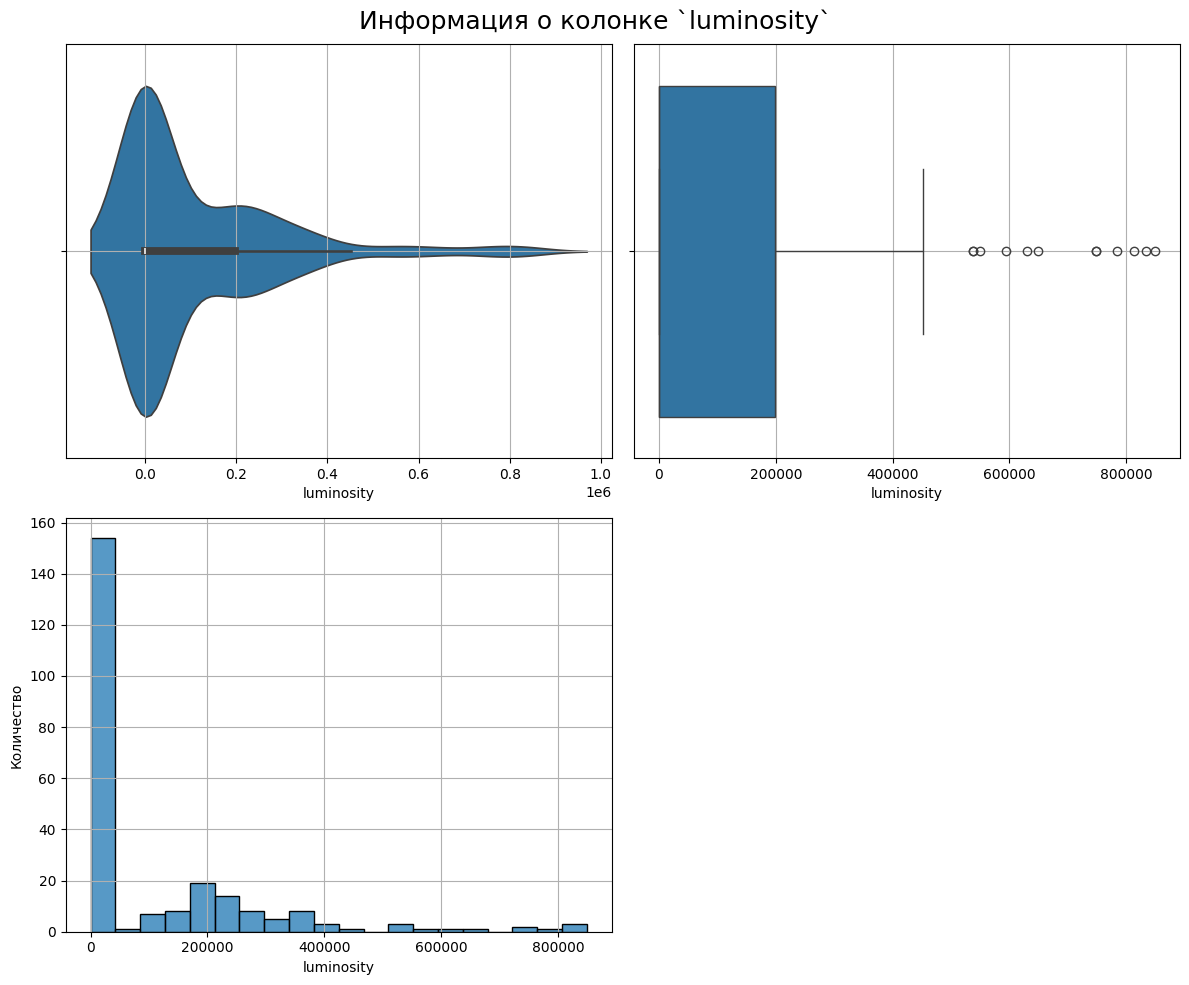

In [21]:
draw_plots_about_column(df, 'luminosity')

Видим, что признак крайне сильно смещен. Поэтому логарифмируем его.

In [22]:
df['luminosity_log'] = df['luminosity'].apply(np.log)
df = df.drop(columns='luminosity')

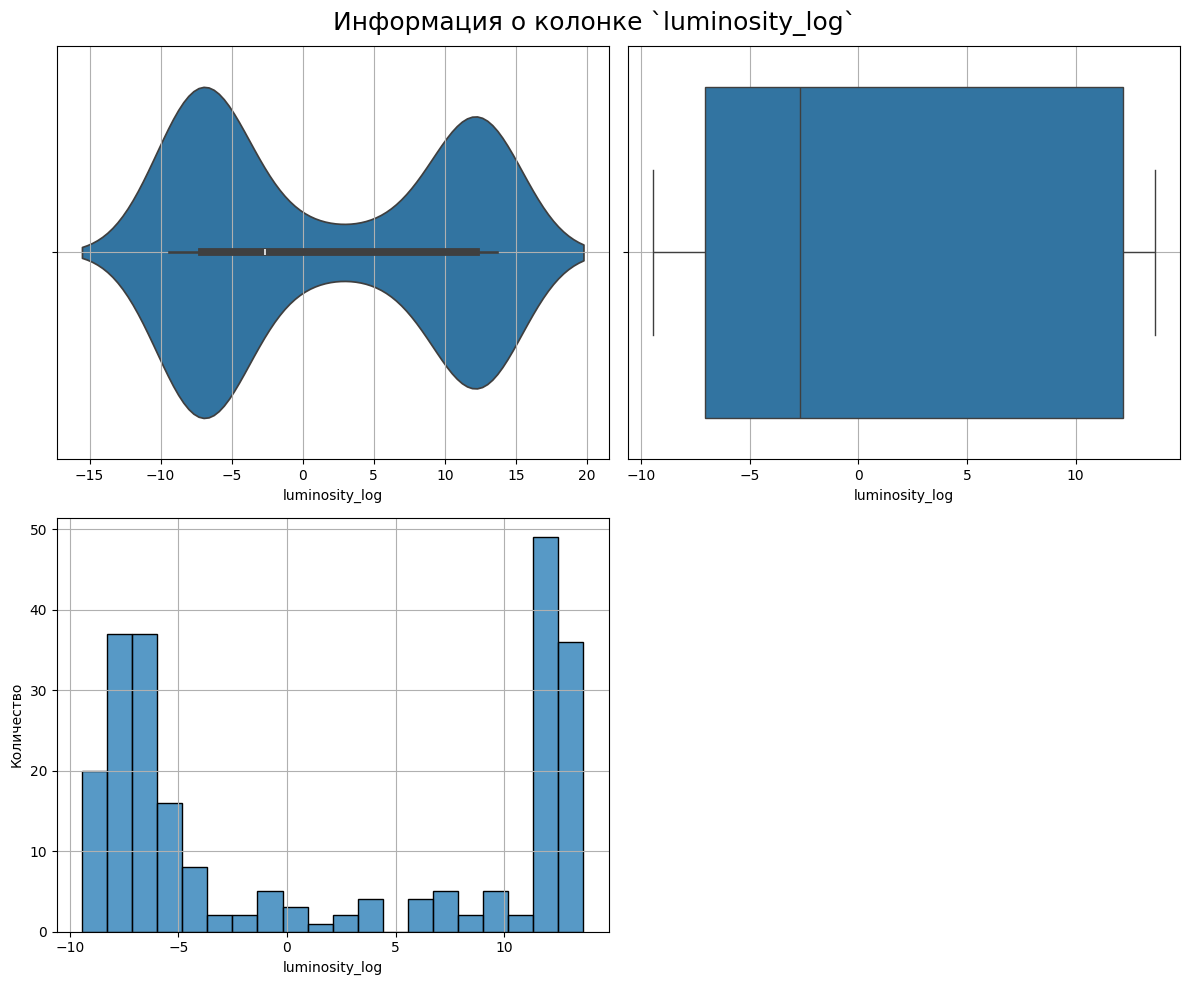

In [23]:
draw_plots_about_column(df, 'luminosity_log')

#### 2.6.3. <a id='toc2_6_3_'></a>Признак `radius`       [&#8593;](#toc0_)

In [24]:
df['radius'].describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64

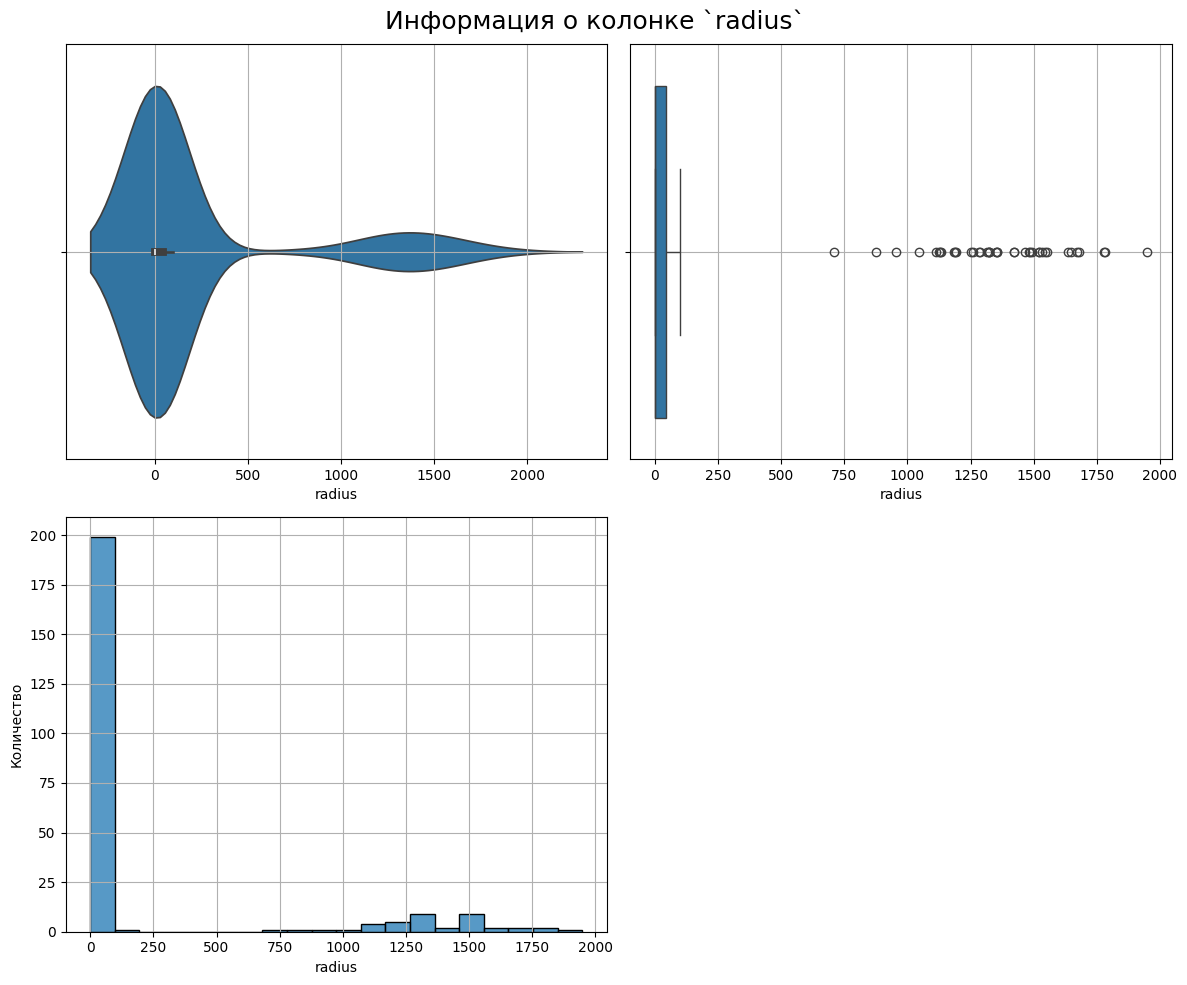

In [25]:
draw_plots_about_column(df, 'radius')

Видим, что признак крайне сильно смещен. Поэтому логарифмируем его.

In [26]:
df['radius_log'] = df['radius'].apply(np.log)
df = df.drop(columns='radius')

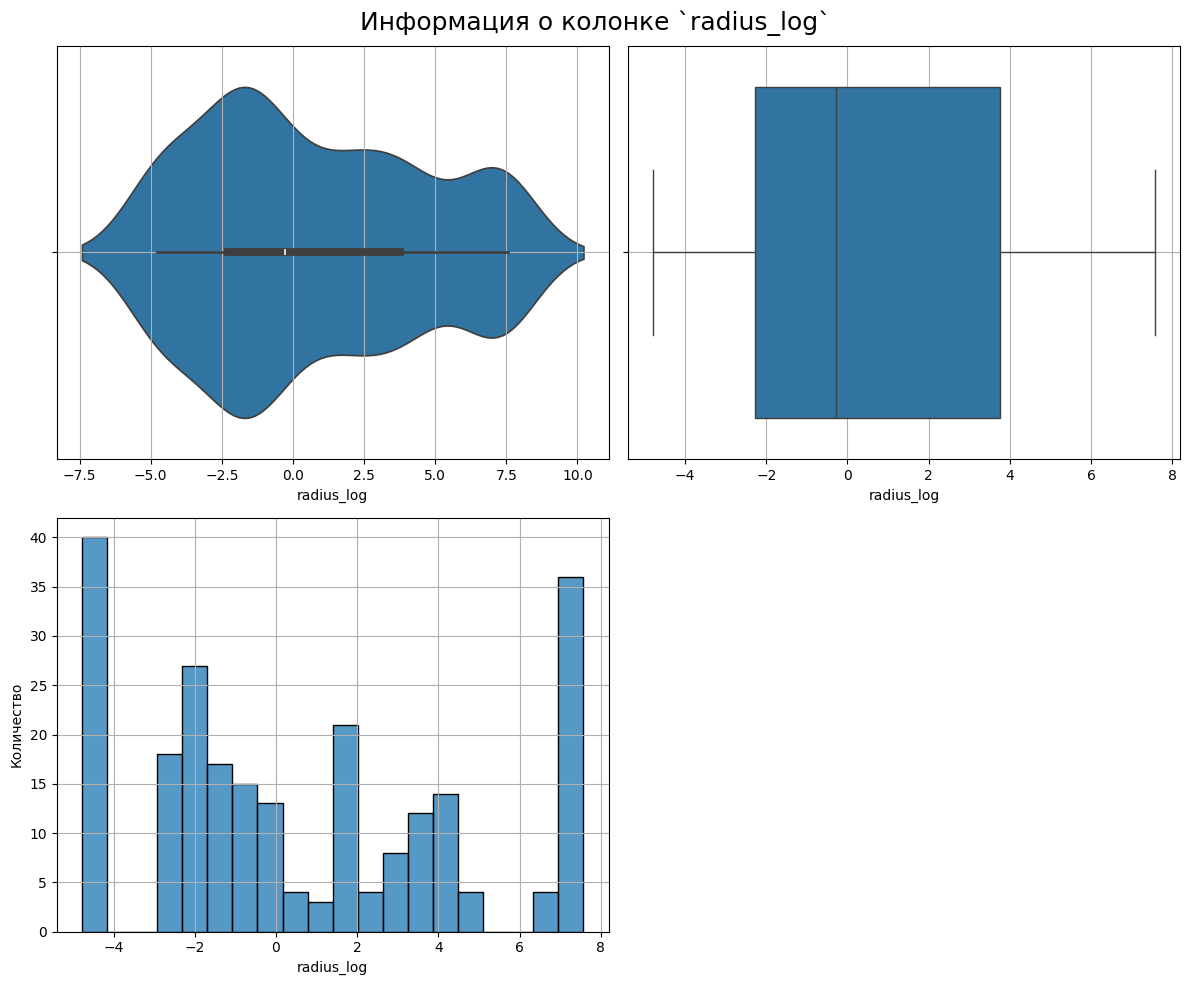

In [27]:
draw_plots_about_column(df, 'radius_log')

#### 2.6.4. <a id='toc2_6_4_'></a>Признак `absolute_magnitude`       [&#8593;](#toc0_)

In [28]:
df['absolute_magnitude'].describe()

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: absolute_magnitude, dtype: float64

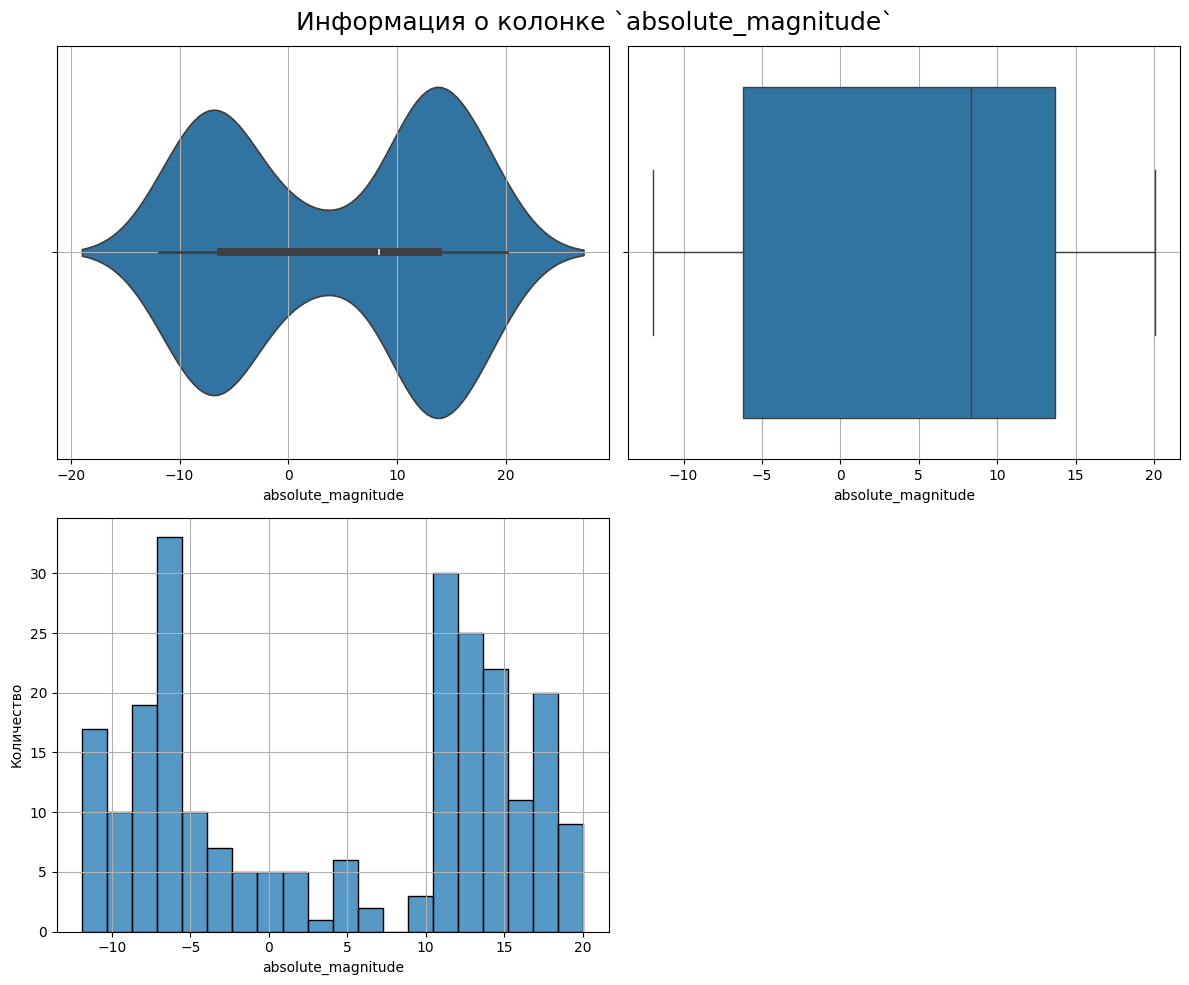

In [29]:
draw_plots_about_column(df, 'absolute_magnitude')

#### 2.6.5. <a id='toc2_6_5_'></a>Признак `star_type`       [&#8593;](#toc0_)

In [30]:
get_value_counts(df['star_type'])

,count,part
star_type,,
0,40,0.166667
1,40,0.166667
2,40,0.166667
3,40,0.166667
4,40,0.166667
5,40,0.166667


Каждого класса представлено ровно по 40 объектов. Относительного данного признака датасет идеально сбалансирован.

#### 2.6.6. <a id='toc2_6_6_'></a>Признак `star_color`       [&#8593;](#toc0_)

In [31]:
get_value_counts(df['star_color'])

,count,part
star_color,,
Red,112,0.466667
Blue,55,0.229167
Blue-white,26,0.108333
Blue White,10,0.041667
yellow-white,8,0.033333
White,7,0.029167
Blue white,3,0.012500
Yellowish White,3,0.012500
white,3,0.012500


Сразу же видно огромное количество неявных дубликатов. Обработаем значения данного столбца, чтобы избавить от дубликатов.

In [32]:
def clear_values(s: str) -> str:
    return s.strip().lower().replace('-', ' ').replace('yellowish', 'yellow').replace('whitish', 'white')

In [33]:
df['star_color'] = df['star_color'].apply(clear_values)

In [34]:
get_value_counts(df['star_color'])

,count,part
star_color,,
red,112,0.466667
blue,56,0.233333
blue white,41,0.170833
white,12,0.050000
yellow white,11,0.045833
yellow,3,0.012500
orange,2,0.008333
pale yellow orange,1,0.004167
white yellow,1,0.004167


Видим, что некоторые цвета встречаются редко. Объединим по группам:

In [35]:
def group_colors(s: str) -> str:
    if s == 'white yellow':
        return 'yellow white'
    elif s == 'pale yellow orange':
        return 'orange'
    elif s == 'orange red':
        return 'red'

    return s

In [36]:
df['star_color'] = df['star_color'].apply(group_colors)

In [37]:
get_value_counts(df['star_color'])

,count,part
star_color,,
red,113,0.470833
blue,56,0.233333
blue white,41,0.170833
white,12,0.050000
yellow white,12,0.050000
orange,3,0.012500
yellow,3,0.012500


Некоторые категории (`orange` и `yellow`) все еще встречаются редко. Заменим их на категорию `other`.

In [38]:
df = replace_rare_values(df, 'star_color')

In [39]:
get_value_counts(df['star_color'])

,count,part
star_color,,
red,113,0.470833
blue,56,0.233333
blue white,41,0.170833
white,12,0.050000
yellow white,12,0.050000
other,6,0.025000


### 2.7. <a id='toc2_7_'></a>Корреляция      [&#8593;](#toc0_)

In [40]:
target = 'temperature'
num_cols = ['luminosity_log', 'radius_log', 'absolute_magnitude', 'star_type']
cat_cols = ['star_color']

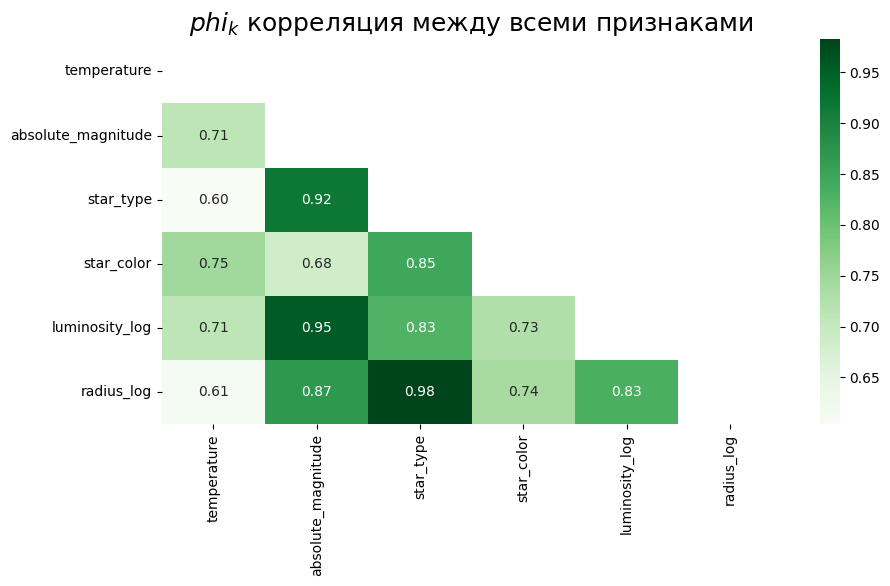

In [41]:
interval_cols = num_cols + [target]
interval_cols.remove('star_type') # хоть и числа, но по сути это категории

plt.figure(figsize=(10, 5))
correlation_matrix = df.phik_matrix(interval_cols=interval_cols)
mask = np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool)
lower_triangle = correlation_matrix.where(mask)
sns.heatmap(lower_triangle,
            cmap='Greens',
            annot=True,
            fmt='.2f');

plt.title(r'$phi_k$ корреляция между всеми признаками', fontsize=18);

In [42]:
scaler = StandardScaler()
df_for_vif = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)

with_constants = add_constant(df_for_vif)

vif_data = pd.DataFrame()
vif_data['variable'] = with_constants.columns
vif_data['vif'] = [variance_inflation_factor(with_constants.values, i) for i in range(with_constants.shape[1])]

vif_data.sort_values(by='vif', ascending=False).reset_index(drop=True)

,variable,vif
0,absolute_magnitude,63.142025
1,luminosity_log,29.674806
2,star_type,15.239303
3,radius_log,6.694164
4,const,1.000000


Видим, что между некоторыми признаками наблюдается мультиколлинеарность. Однако нейронные сети более устойчивы к мультиколлинеарности, нежели линейные модели, поэтому оставим оба признака.

---

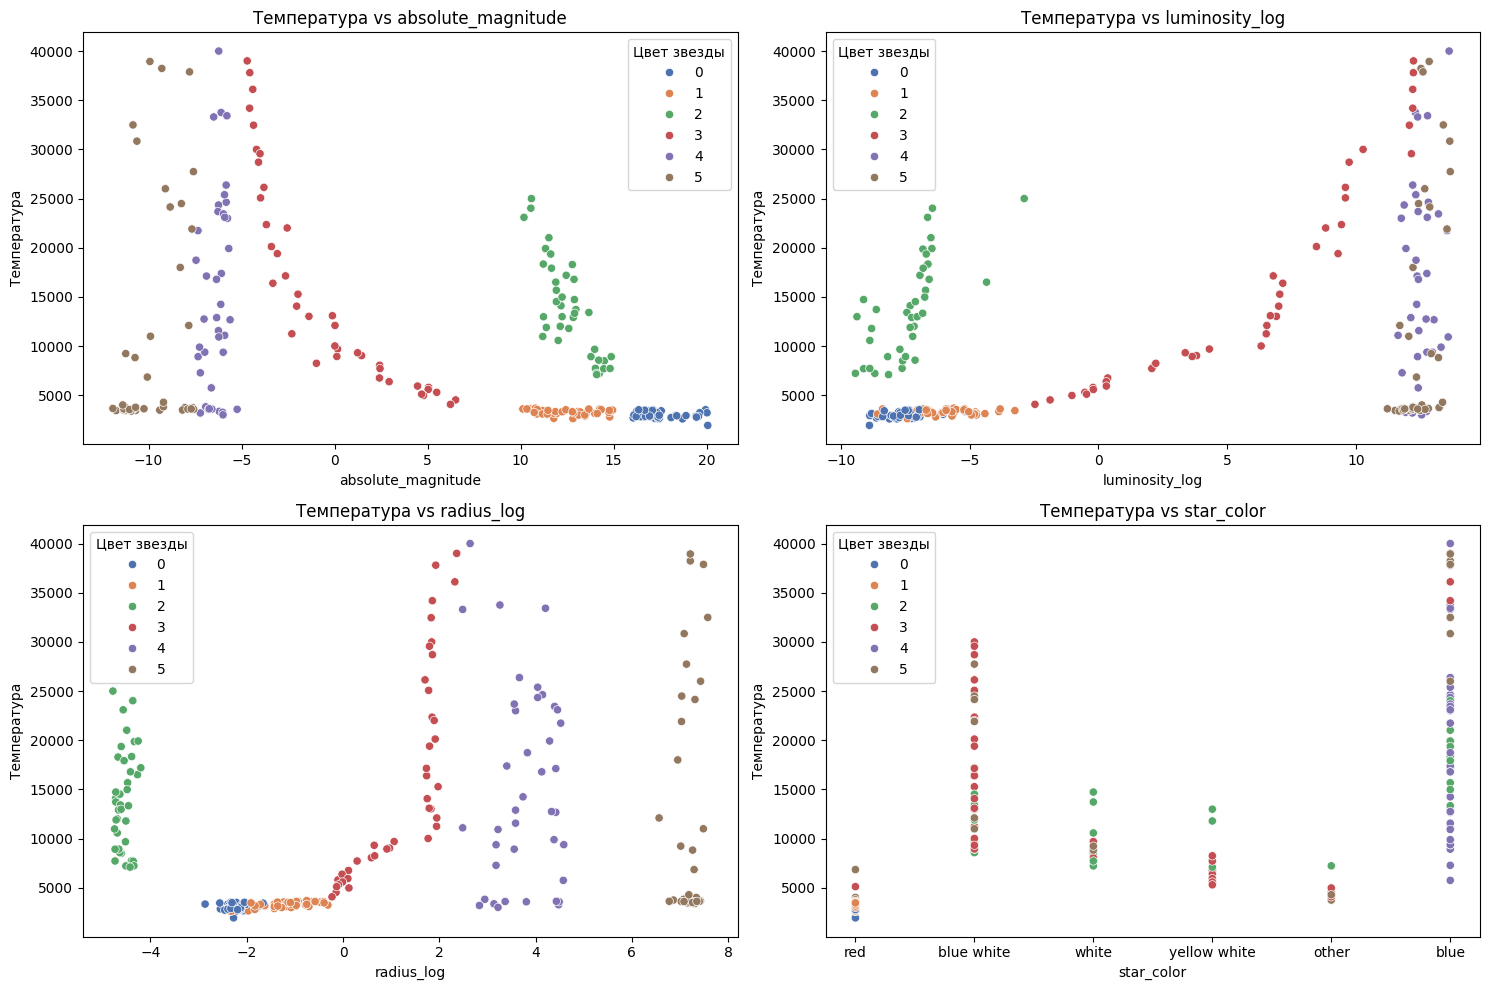

In [43]:
features = ['absolute_magnitude', 'luminosity_log', 'radius_log', 'star_color']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data=df, x=feature, y='temperature', hue='star_type', palette='deep')
    plt.title(f'Температура vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Температура')
    plt.legend(title='Цвет звезды')

plt.tight_layout()
plt.show()

### 2.8. <a id='toc2_8_'></a>Вывод по датафрейму      [&#8593;](#toc0_)

Перед нами крайне небольшой датасет (240 записей) с информацией о звездах. Целевым признаков является температуры звезды. На вход подаются  следующие признаки:
- `absolute_magnitude`
- `star_type`
- `star_color`
- `luminosity`
- `radius`

Датасет не имеет пропусков и полных дубликатов. Большое количество неявных дубликатов обнаружены в признаке `star_color`. Они были обработаны, после чего значения данного признака были объединены в более крупные группы. Также были логарифмированы признаки `radius` и `luminosity`, чтобы устранить *скошенность*.

Часть входных признаков имеет высокую корреляцию друг с другом. Целевой признак имеет корреляцию выше среднего со всеми входными.

## 3. <a id='toc3_'></a>Разделение данных      [&#8593;](#toc0_)

In [44]:
X = df.drop(columns=target)
y = df[target]

X.shape, y.shape

((240, 5), (240,))

In [45]:
X.head()

,absolute_magnitude,star_type,star_color,luminosity_log,radius_log
,,,,,
0,16.12,0,red,-6.032287,-1.771957
1,16.60,0,red,-7.600902,-1.869505
2,18.70,0,red,-8.111728,-2.282782
3,16.65,0,red,-8.517193,-1.832581
4,20.06,0,red,-8.888257,-2.273026


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=X['star_color'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(192, 5) (192,)
(48, 5) (48,)


## 4. <a id='toc4_'></a>Преобразование данных      [&#8593;](#toc0_)

In [47]:
transformer = ColumnTransformer([
    ('num_transformer', StandardScaler(), num_cols),
    ('cat_transformer', OneHotEncoder(), cat_cols)
])

In [48]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [49]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

## 5. <a id='toc5_'></a>Простая сеть   [&#8593;](#toc0_)

### 5.1. <a id='toc5_1_'></a>Создание   [&#8593;](#toc0_)

In [50]:
class SimpleNet(nn.Module):
    def __init__(self, n_in_neurons: int, n_hidden_neurons_1: int, n_hidden_neurons_2: int, n_out_neurons: int):
        super(SimpleNet, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)

        return x

In [51]:
def plot_result(actual: torch.Tensor, predicted: torch.Tensor) -> None:
    """Строит график фактических и предсказанных значений.

    Args:
        actual (torch.Tensor): Тензор с фактическими значениями.
        predicted (torch.Tensor): Тензор с предсказанными значениями.
    """
    if actual.size(0) != predicted.size(0):
        raise ValueError('Длины тензоров должны совпадать.')

    # Индексы для оси X
    indices = torch.arange(len(actual))

    # Ширина столбиков
    width_actual = 0.6  # Ширина для фактических значений
    width_predicted = 0.3  # Ширина для предсказанных значений

    # Создаем гистограмму
    plt.figure(figsize=(20, 8))

    # Накладываем фактические значения
    plt.bar(indices.numpy(), actual.numpy(), width=width_actual, label='Фактические значения', alpha=0.7)

    # Накладываем предсказанные значения
    plt.bar(indices.numpy(), predicted.squeeze().numpy(), width=width_predicted, label='Предсказанные значения', alpha=0.7)

    # Настраиваем график
    plt.title('Фактические и предсказанные значения')
    plt.xlabel('Индекс')
    plt.ylabel('Значение')
    plt.xticks(indices.numpy())  # Устанавливаем метки по оси X
    plt.legend()
    plt.grid(axis='y')

    # Показываем график
    plt.show()

In [52]:
def train_net_and_get_result(X_train, X_test, y_train, y_test, net: SimpleNet, num_epochs: int) -> float:
    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()

        preds = net.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 500 == 0 or epoch == num_epochs - 1:
            net.eval()
            with torch.no_grad():
                test_preds = net.forward(X_test)
                rmse = root_mean_squared_error(y_test, test_preds)
                print(f'Epoch {epoch:5}: RMSE = {rmse:.2f}')

    plot_result(y_test, test_preds)

    return rmse

Epoch     0: RMSE = 13024.32
Epoch   500: RMSE = 4582.36
Epoch  1000: RMSE = 4560.75
Epoch  1500: RMSE = 4531.97
Epoch  2000: RMSE = 4511.33
Epoch  2500: RMSE = 4501.45
Epoch  3000: RMSE = 4392.46
Epoch  3500: RMSE = 4067.12
Epoch  4000: RMSE = 4095.97
Epoch  4500: RMSE = 4103.55
Epoch  4999: RMSE = 4157.51


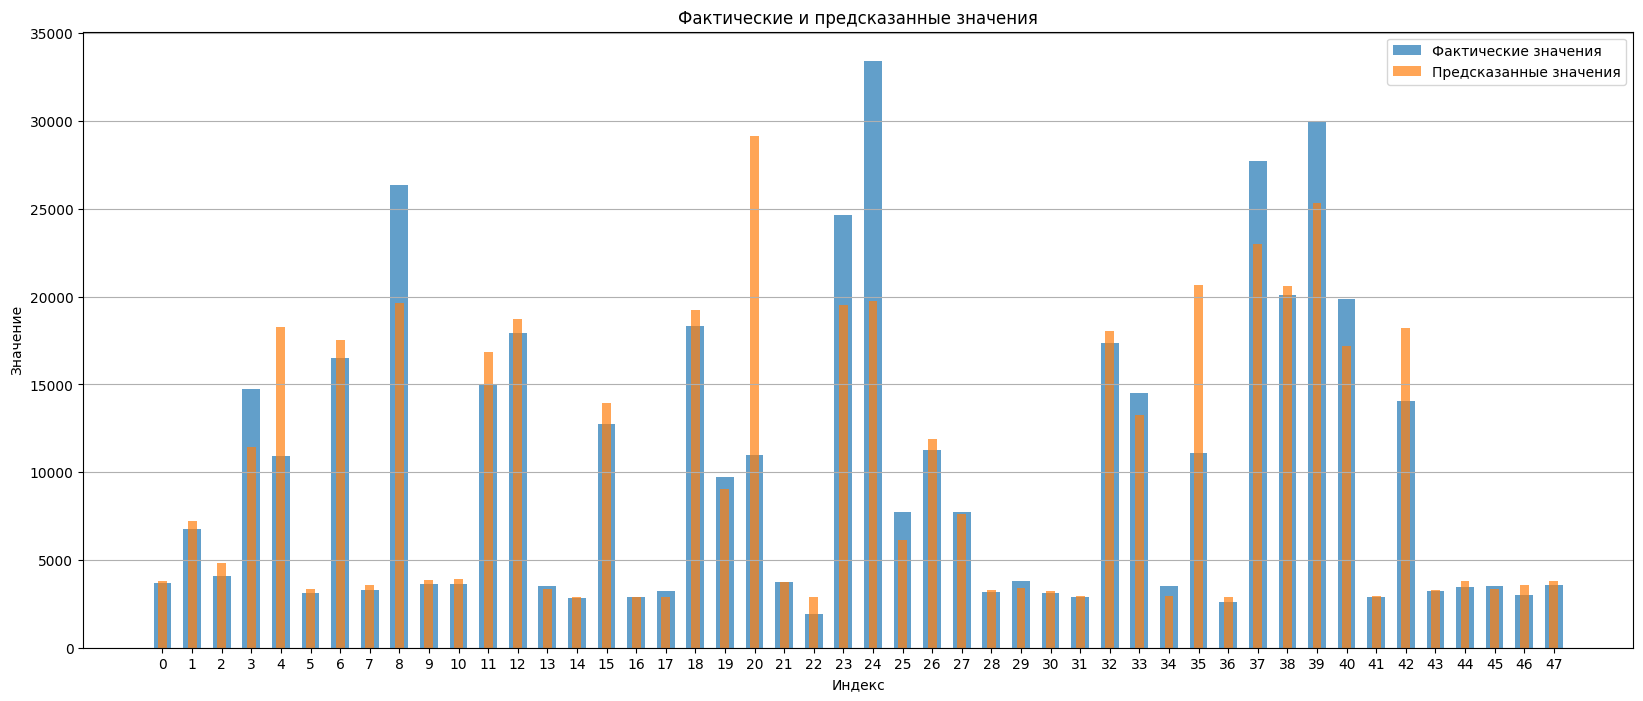

In [53]:
in_num = X_train.size(1)
net = SimpleNet(in_num, in_num * 2, in_num, 1)
rmse = train_net_and_get_result(X_train, X_test, y_train, y_test, net, 5_000)

### 5.2. <a id='toc5_2_'></a>Вывод   [&#8593;](#toc0_)

Простая (только линейные слои и функции активации) нейронная сеть показала неплохие результаты. Примерно за 3000 эпох модель побила целевую метрику `RMSE <= 4500`. Далее уже началось переобучение, что показывает ухудшение метрики на тестовой выборке.

По графике видно, что модель очень неплохо справляется с теми записями, где значение таргета небольшое (не более 7000). А вот для больших значений уже наблюдаются серьезные ошибки, причем в обе стороны: как сильное занижение, так и сильное завышение. Возможно, сказывается крайне небольшое количество данных для обучения.

## 6. <a id='toc6_'></a>Улучшение модели      [&#8593;](#toc0_)

Создадим новый класс для более сложной сети.

In [54]:
class Net(nn.Module):
    def __init__(self,
                 n_in_neurons: int,
                 n_hidden_neurons_1: int,
                 n_hidden_neurons_2: int,
                 n_out_neurons: int,
                 dropout_p_1: float,
                 dropout_p_2: float):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp1 = nn.Dropout(p=dropout_p_1)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(p=dropout_p_2)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)

        x = self.fc3(x)

        return x

In [55]:
model = NeuralNetRegressor(
    module=Net,
    module__n_in_neurons=in_num,
    module__n_hidden_neurons_1=in_num * 2,
    module__n_hidden_neurons_2=in_num,
    module__n_out_neurons=1,
    module__dropout_p_1=None,
    module__dropout_p_2=None,
    batch_size=None,
    max_epochs=None,
    lr=None,
    optimizer=torch.optim.Adam,
    verbose=0,
    callbacks=[
        ('early_stopping', EarlyStopping(patience=100))
    ]
)

In [56]:
param_distributions = {
    'module__dropout_p_1': np.linspace(0.2, 0.5, 4),
    'module__dropout_p_2': np.linspace(0.2, 0.5, 4),
    'lr': [0.1, 0.5, 1],
    'max_epochs': np.arange(3000, 7001, 500),
    'batch_size': [-1, 64, 128]
}

In [57]:
rs = RandomizedSearchCV(model,
                        param_distributions,
                        n_iter=10_000,
                        scoring='neg_root_mean_squared_error',
                        cv=2,
                        random_state=RANDOM_STATE)

In [58]:
rs.fit(X_train, y_train);

In [59]:
print('Best params: ', rs.best_params_)
print(f'Best RMSE on train = {-rs.best_score_:.2f}')

Best params:  {'module__dropout_p_2': 0.5, 'module__dropout_p_1': 0.3, 'max_epochs': 5500, 'lr': 1, 'batch_size': 64}
Best RMSE on train = 8687.41


Сеть с дропаут слоями показала крайне неудовлетворительные результаты, более чем в 2 раза уступающие "простой" модели.

## 7. <a id='toc7_'></a>Проверка на тесте     [&#8593;](#toc0_)

In [60]:
best_model = rs.best_estimator_

In [61]:
y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE on test = {rmse:.2f}')

RMSE on test = 7769.58


Метрика на тесте уже лучше (хотя все равно до целевой метрики далеко). Судя по тому, что метрика на тесте сильно лучше, чем на тренировочной, можно предположить, что модель не обучилась до конца (underfit).

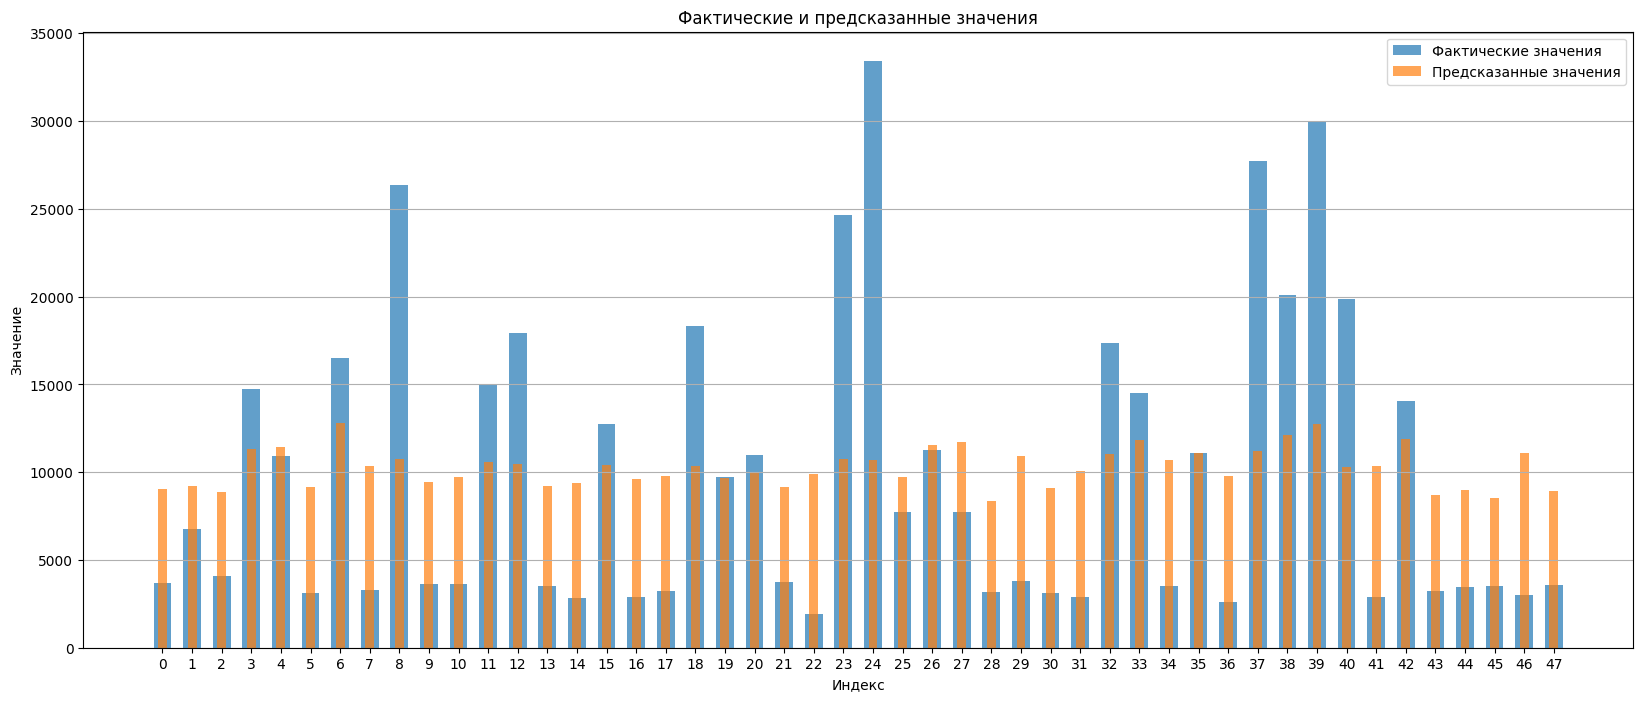

In [62]:
plot_result(y_test, torch.tensor(y_pred))

График подтверждает вывод выше. Модель предсказывает для любых входных данных примерно одно значение. Скорее всего действительно произошло недообучение. Можно попробовать заменить дропаут слои на batch normalization или попробовать увеличить количество нейронов в скрытых слоях.

## 8. <a id='toc8_'></a>Общий вывод     [&#8593;](#toc0_)

В рамках данного проекта мы работали с небольшим датасетом о звездах. Целевым признаком является их температура, следовательно перед нами задачи регрессии.

Целевой признак - `temperature`  
Входные признаки:
- `luminosity` - относительная светимость звезды относительно Солнца
- `radius` - относительный радиус звезды относительно радиуса Солнца
- `absolute_magnitude` - абсолютная звездная величина, характеризующая блеск звезды
- `star_type` - тип звезды (белый карлик, сверхгигант и т.д.)
- `star_color` - цвет звезды, который определяют на основе спектрального анализа.

Во время изучения датасета были сделаны следующие выводы:
- датасет не содержит пропусков
- датасет не содержит полных дубликатов
- почти все данные числовые (кроме `star_color`)
- признак `star_color` содержал много неявных дубликатов, они были устранены.

Анализ корреляции говорит о следующем:
- Много входных признаков имеют корреляцию друг с другом.
- Все входные признаки имеют и средний и выше среднего уровень корреляции с таргетом
- Видим, что между признаками `star_type` и `absolute_magnitude` наблюдается мультиколлинеарность. Однако нейронные сети более устойчивы к мультиколлинеарности, нежели линейные модели, поэтому оба признака были оставлены.

Сначала была разработана простая полносвязная нейронная сеть (`SimpleNet`) с 2 скрытыми слоями. Количество нейронов следующее: 11 -> 22 -> 11 -> 1. За 3000 эпох обучения  метрика RMSE на test выборке составила чуть больше `4000`. Однако после началось переобучение.

Далее была создана более сложная сеть с дропаут слоями. Более того, в ней реализовано обучение по батчам и механизм early stopping. Также с помощью RandomizedSearchCV был реализован подбор гиперпараметров. Однако данная сеть не смогла обучиться, поэтому показала крайне плохие результаты.

В результате целевая метрика была достигнута с помощью "простой" нейронной сети без дропаут слоев и без обучения по батчам (что вообще не очень целесообразно при таком размере датасета).